In [3]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits
import skimage as ski

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB


In [4]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
reg_param = 5e4
mu = 20


img_name = 'M31'
# It could be any of these ['M31', 'W28', 'CYN', '3c288']


# Load models and data

In [5]:
# %%
# Load image and mask
img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()



INSTRUME                                                                         [astropy.io.fits.card]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


In [7]:
# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


# Optimisation

In [6]:

# Prior parameters
lmbd = reg_param

# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1

# Accelerated gradient descend
for it_2 in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    
    x_hat = z - alpha *(
        g.grad(z) + lmbd * model(mu * z)
    )
    # Reality constraint
    x_hat = f.prox(x_hat)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                options['iter'],
                res,
            )
        )



[GD] 0 out of 15000 iterations, tol = 0.074123
[GD] converged in 1032 iterations


In [8]:
np_x_hat = to_numpy(x_hat)
np_x = np.copy(x)

# Evaluate performance
print('PSNR: ', psnr(np_x, np_x_hat, data_range=np_x.max()-np_x.min()))
print('SNR: ', luq.utils.eval_snr(x, np_x_hat))


PSNR:  55.26011847614987
SNR:  32.82


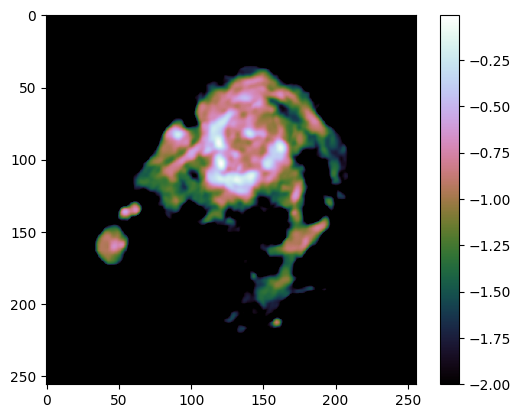

In [9]:
plt.figure()
plt.imshow(np.log10(abs(np_x_hat)), cmap='cubehelix', vmin=-2)
plt.colorbar()
plt.show()


# MAP-based pixel UQ

In [11]:
### MAP-based UQ

# Parameters
alpha_prob = 0.01
superpix_size = 8

# LCI compute parameters
LCI_iters = 200  # Max iterations
LCI_tol = 1e-4
LCI_bottom = -10
LCI_top = 10

# Clipping values for MAP-based LCI. Set as None for no clipping
clip_high_val = 1.
clip_low_val = 0.


In [12]:

# Function handle for the potential
def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

# Evaluation of the potential
fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()

# Compute HPD region bound
N = np_x_hat.size
tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
gamma_alpha = fun(x_hat).item() + tau_alpha*np.sqrt(N) + N


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


In [13]:

# Compute upper and lower uncertainty bounds
error_p, error_m, mean = luq.map_uncertainty.create_local_credible_interval(
    x_sol=np_x_hat,
    region_size=superpix_size,
    function=fun_np,
    bound=gamma_alpha,
    iters=LCI_iters,
    tol=LCI_tol,
    bottom=LCI_bottom,
    top=LCI_top,
)

# Clip plot values
error_length = luq.utils.clip_matrix(
    np.copy(error_p), clip_low_val, clip_high_val
) - luq.utils.clip_matrix(
    np.copy(error_m), clip_low_val, clip_high_val
)

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.


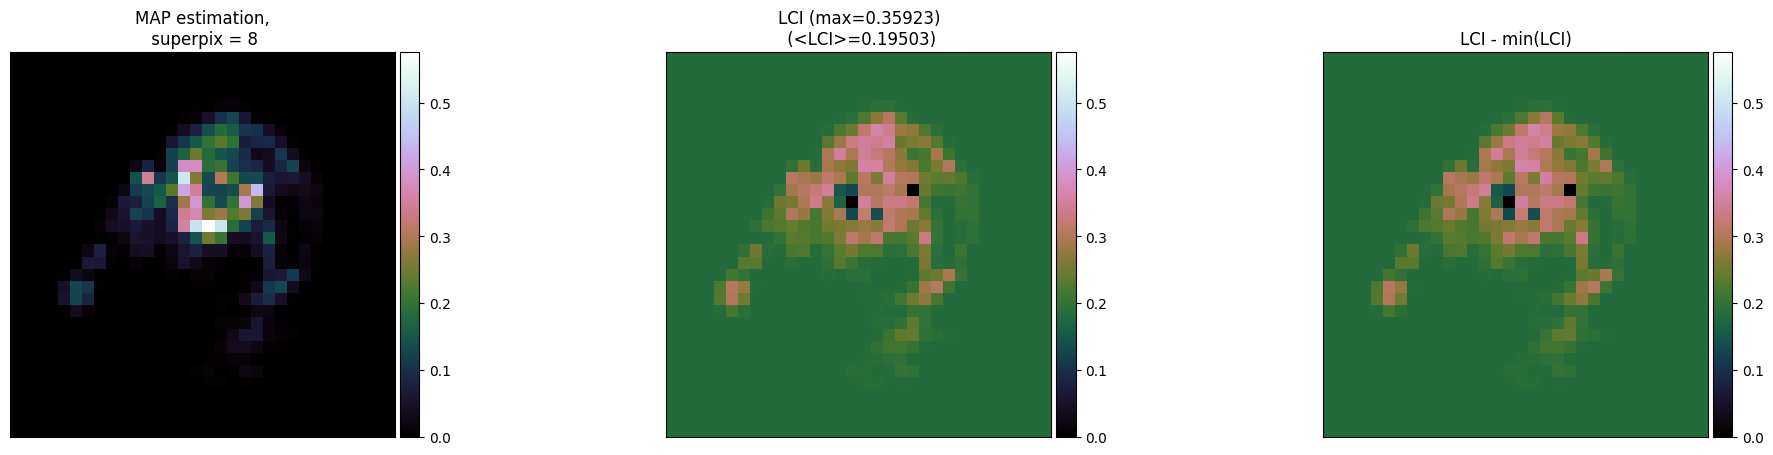

In [14]:

# Plot UQ
cmap = 'cubehelix'
vmin = np.min((mean, error_length))
vmax = np.max((mean, error_length))

fig = plt.figure(figsize=(24,5))

plt.subplot(131)
ax = plt.gca()
ax.set_title('MAP estimation,\n superpix = {:d}'.format(superpix_size))
im = ax.imshow(mean, cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])

plt.subplot(132)
ax = plt.gca()
ax.set_title('LCI (max={:.5f})\n (<LCI>={:.5f})'.format(
        np.max(error_length), np.mean(error_length)
    )
)
im = ax.imshow(error_length, cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])

plt.subplot(133)
ax = plt.gca()
ax.set_title('LCI - min(LCI)')
im = ax.imshow(error_length - np.min(error_length), cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])

plt.show()

